In [104]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm as tqdm
import unicodedata
import pycocotools

import re
import random 
import itertools
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dir = "/content/drive/MyDrive/cocodataset/"

In [105]:
import os 
import sys
from pycocotools.coco import COCO
import urllib
import zipfile

In [106]:
os.makedirs('/content/opt' , exist_ok=True)
os.chdir( '/content/opt' )
!git clone 'https://github.com/cocodataset/cocoapi.git'

fatal: destination path 'cocoapi' already exists and is not an empty directory.


In [107]:
os.chdir('/content/opt/cocoapi')

# Download the annotation : 
annotations_trainval2014 = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
image_info_test2014 = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'


urllib.request.urlretrieve(annotations_trainval2014 , filename = 'annotations_trainval2014.zip' )
urllib.request.urlretrieve(image_info_test2014 , filename= 'image_info_test2014.zip' )


('image_info_test2014.zip', <http.client.HTTPMessage at 0x7fbab2e67860>)

In [108]:
with zipfile.ZipFile('annotations_trainval2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )  

try:
  os.remove( 'annotations_trainval2014.zip' )
  print('zip removed')
except:
  None

with zipfile.ZipFile('image_info_test2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )  

try:
  os.remove( 'image_info_test2014.zip' )
  print('zip removed')
except:
  None


zip removed
zip removed


In [109]:
import matplotlib.pyplot as plt 
import skimage.io as io 
import numpy as np 
%matplotlib inline

In [110]:
# #Pick a random annotation id and display img of that annotation  :
# ann_id = np.random.choice( ids )
# img_id = coco.anns[ann_id]['image_id']
# img = coco.loadImgs( img_id )[0]
# url = img['coco_url']
# print(url)
# I = io.imread(url)
# plt.imshow(I)

# # Display captions for that annotation id :
# ann_ids = coco_caps.getAnnIds( img_id   )
# print('Number of annotations i.e captions for the image: ' , ann_ids)
# print()
# anns = coco_caps.loadAnns( ann_ids )
# coco_caps.showAnns(anns)

In [111]:
os.chdir('/content/opt/cocoapi')

train2014 = 'http://images.cocodataset.org/zips/train2014.zip'
#test2014 = 'http://images.cocodataset.org/zips/test2014.zip'
#val2014 = 'http://images.cocodataset.org/zips/val2014.zip'

urllib.request.urlretrieve( train2014 , 'train2014' )
#urllib.request.urlretrieve( test2014 , 'test2014' )
#urllib.request.urlretrieve( val2014 , 'val2014' )

('train2014', <http.client.HTTPMessage at 0x7fbab2e67b00>)

In [112]:
os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'train2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'train2014' )
  print('zip removed')
except:
  None

zip removed


In [113]:
import glob
files = glob.glob("/content/opt/cocoapi/images/train2014/*.jpg",recursive=True)
len(files)

82783

In [114]:
data_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

coco_train_caption = dset.CocoCaptions(root="/content/opt/cocoapi/images/train2014",annFile="/content/opt/cocoapi/annotations/captions_train2014.json",transform=data_transform)

loading annotations into memory...
Done (t=1.85s)
creating index...
index created!


In [115]:
img_caption,target_caption = coco_train_caption[1]

In [116]:
data_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

coco_train_detection = dset.CocoDetection(root="/content/opt/cocoapi/images/train2014",annFile="/content/opt/cocoapi/annotations/instances_train2014.json")#,transform=data_transform)

loading annotations into memory...
Done (t=23.17s)
creating index...
index created!


In [117]:
img_detection,target_detection = coco_train_detection[1]

In [118]:
img_caption.size()
original_shape = np.array(img_detection).shape
print(original_shape)

(426, 640, 3)


In [119]:
def bbox_transform_coco2cv(b,wratio,hratio):
    b = [b[0]*wratio,b[1]*hratio,b[2]*wratio,b[3]*hratio]
    temp = [b[0],b[1]]
    temp.append(b[0]+b[2])
    temp.append(b[1]+b[3])
    for i in range(len(temp)):
        temp[i] = int(temp[i])
    temp2 = [temp[1],temp[0],temp[3],temp[2]]
    return np.array(temp).astype(int),temp2 #(x1,y1,x2,y2)

Preprocessing captions

In [120]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [121]:
SOS_token = 1
EOS_token = 2
PAD_token = 0
UNK_token = 3

class Vocabulary:
    
    def __init__(self,name):
        self.word2index = {"SOS":1,"EOS":2,"UNK":3,"PAD":0}
        self.index2word = {1:"SOS",2:"EOS",3:"UNK",0:"PAD"}
        self.word2count = {}
        self.nwords = 4
        
    def addSentence(self,sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self,word):
        if word not in list(self.word2index.keys()):
            self.word2index[word] = self.nwords
            self.index2word[self.nwords] = word
            self.word2count[word] = 1
            self.nwords += 1
        else:
            self.word2count[word] += 1
            
    def save(self,word2index_dic = 'word2index_dic', index2word_dic = 'index2word_dic',
         word2count_dic = 'word2count_dic'):

        with open('/content/Save/'+word2index_dic+'.p', 'wb') as fp:
            pickle.dump(self.word2index, fp, protocol=pickle.HIGHEST_PROTOCOL)

        with open('/content/Save/'+index2word_dic+'.p', 'wb') as fp:
            pickle.dump(self.index2word, fp, protocol=pickle.HIGHEST_PROTOCOL)

        with open('/content/Save/'+word2count_dic+'.p', 'wb') as fp:
            pickle.dump(self.word2count, fp, protocol=pickle.HIGHEST_PROTOCOL)

    def load(self, word2index_dic = 'word2index_dic', index2word_dic = 'index2word_dic',
             word2count_dic = 'word2count_dic'):
        
        with open('/content/Save/'+word2index_dic+'.p', 'rb') as fp:
            self.word2index = pickle.load(fp)
            
        with open('/content/Save/'+index2word_dic+'.p', 'rb') as fp:
            self.index2word = pickle.load(fp)
            
        with open('/content/Save/'+word2count_dic+'.p', 'rb') as fp:
            self.word2count = pickle.load(fp)
            
        self.nwords = len(self.word2index)

            
voc = Vocabulary('COCO_TRAIN')
#voc.load()

In [122]:
import pickle
# for _,target in tqdm.tqdm(coco_train_caption):
#     for sen in target:
#         voc.addSentence(normalizeString(sen))
        
# voc.save()
voc.load()

In [123]:

class COCO14Dataset(Dataset):
    def __init__(self,coco_caption,coco_detection,voc,transforms=None):
        self.coco_caption = coco_caption
        self.coco_detection = coco_detection
        self.voc = voc
        self.transforms = transforms
    def __len__(self):
        return len(self.coco_caption)
    def __getitem__(self,idx):
        img,target = self.coco_caption[idx]
        img_detection,detection_target = self.coco_detection[idx]
        
        
        original_shape = np.array(img_detection).shape

        lbl = normalizeString(random.choice(target))
        label = []
        for s in lbl.split(' '):
            if s in list(voc.word2count.keys()):
                label.append(voc.word2index[s])
            else:
                label.append(UNK_token)
        label = [SOS_token]+label +[EOS_token]
        
        bounding_box = []
        bounding_box_category = []
        wratio = (224*1.0)/original_shape[0]
        hratio = (224*1.0)/original_shape[1]

        for i in range(len(detection_target)):
          bnding_box = detection_target[i]['bbox']
          b_category = detection_target[i]['category_id']
          bbox_plt ,_ = bbox_transform_coco2cv(bnding_box,hratio,wratio)
          bounding_box.append(list(bbox_plt))
          bounding_box_category.append(b_category)


        return img, label,bounding_box,bounding_box_category

In [124]:
batch_size = 32
train_dset = COCO14Dataset(coco_train_caption,coco_train_detection,voc,transforms=data_transform)

def collate_fn(batch):
    data = [item[0] for item in batch]
    images = torch.stack(data,0)
    
    label = [item[1] for item in batch]
    max_target_len = max([len(indexes) for indexes in label])
    padList = list(itertools.zip_longest(*label, fillvalue = 0))
    lengths = torch.tensor([len(p) for p in label])
    padVar = torch.LongTensor(padList)
    bounding_box = [item[2] for item in batch]
    bounding_box_category = [item[3] for item in batch]
   
   
    m = []
    for i, seq in enumerate(padVar):
        #m.append([])
        tmp = []
        for token in seq:
            if token == 0:
                tmp.append(int(0))
            else:
                tmp.append(1)
        m.append(tmp)
    m = torch.tensor(m)
    
    return images, padVar, m, max_target_len,bounding_box,bounding_box_category

train_loader=DataLoader(train_dset,batch_size = batch_size, num_workers = 8,shuffle = False,
                    collate_fn = collate_fn, drop_last=True)

## Exploratory Data Analysis on COCO datasets



In [125]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pdb
import os
from pycocotools.coco import COCO
from skimage import io

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

## Setting the root directory and annotation json file

In [126]:

# src_root = '../../../../datasets/voc2012/'
# src_subset = 'images/'
# src_file = src_root+'annotations/instances_train2012.json'
# src_desc = 'train2017_voc12' 

src_root = '../../../../datasets/coco/'
src_subset = '/content/opt/cocoapi/images/train2014'
src_file = '/content/opt/cocoapi/annotations/instances_train2014.json'
src_desc = 'train2014_coco' # a name (identifier) for the dataset
annotation_file = '/content/opt/cocoapi/annotations/captions_train2014.json'

coco_obj = COCO(src_file)

loading annotations into memory...
Done (t=20.30s)
creating index...
index created!


In [127]:
# Reading the json file
with open(src_file, 'r') as f:
    root = json.load(f)

root.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [128]:
with open(annotation_file, 'r') as f:
    caption = json.load(f)

caption.keys()

dict_keys(['info', 'images', 'licenses', 'annotations'])

In [173]:
# caption['annotations']

In [130]:
# root['annotations']
root['categories']

[{'id': 1, 'name': 'person', 'supercategory': 'person'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'vehicle'},
 {'id': 3, 'name': 'car', 'supercategory': 'vehicle'},
 {'id': 4, 'name': 'motorcycle', 'supercategory': 'vehicle'},
 {'id': 5, 'name': 'airplane', 'supercategory': 'vehicle'},
 {'id': 6, 'name': 'bus', 'supercategory': 'vehicle'},
 {'id': 7, 'name': 'train', 'supercategory': 'vehicle'},
 {'id': 8, 'name': 'truck', 'supercategory': 'vehicle'},
 {'id': 9, 'name': 'boat', 'supercategory': 'vehicle'},
 {'id': 10, 'name': 'traffic light', 'supercategory': 'outdoor'},
 {'id': 11, 'name': 'fire hydrant', 'supercategory': 'outdoor'},
 {'id': 13, 'name': 'stop sign', 'supercategory': 'outdoor'},
 {'id': 14, 'name': 'parking meter', 'supercategory': 'outdoor'},
 {'id': 15, 'name': 'bench', 'supercategory': 'outdoor'},
 {'id': 16, 'name': 'bird', 'supercategory': 'animal'},
 {'id': 17, 'name': 'cat', 'supercategory': 'animal'},
 {'id': 18, 'name': 'dog', 'supercategory': 'animal'},

## Basic High Level Information

In [131]:
# Basic High Level Information

n_images = len(root['images'])
n_boxes = len(root['annotations'])
n_categ = len(root['categories'])

# height, width
heights = [x['height'] for x in root['images']]
widths = [x['width'] for x in root['images']]




print('Dataset Name: ',src_desc)
print('Number of images: ',n_images)
print('Number of bounding boxes: ', n_boxes)
print('Number of classes: ', n_categ)
print('Max min avg height: ', max(heights), min(heights), int(sum(heights)/len(heights)))
print('Max min avg width: ', max(widths), min(widths), int(sum(widths)/len(widths)))

Dataset Name:  train2014_coco
Number of images:  82783
Number of bounding boxes:  604907
Number of classes:  80
Max min avg height:  640 51 483
Max min avg width:  640 59 578


## Distribution of objects across images

In [132]:
# Objects per image distribution

img2nboxes = {} # mapping "image id" to "number of boxes"

for ann in root['annotations']:
    img_id = ann['image_id']
    
    if img_id in img2nboxes.keys():
        img2nboxes[img_id] += 1
    else:
        img2nboxes[img_id] = 1

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

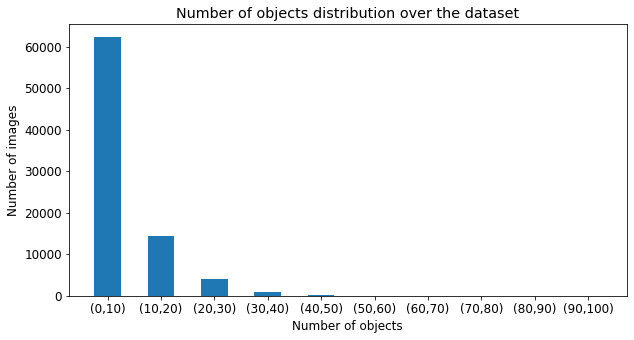

Number of images having atleast one box:  82081
Min number of boxes per image:  1
Max number of boxes per image:  93
Avg number of boxes per image:  7


In [133]:
out = pd.cut(nboxes_list, bins=np.arange(0,max_nboxes+10,10), include_lowest=True)

counts = out.value_counts().values
labels = [(int(i.left),int(i.right)) for i in out.value_counts().index.categories]

graph_xind = [i[0] for i in labels] 
ticks = [ '('+str(i[0])+','+ str(i[1])+')' for i in labels]

plt.figure(figsize=(10,5))
plt.bar(graph_xind, counts, tick_label=ticks, width=5)
plt.xlabel('Number of objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution over the dataset')
plt.show()

print("Number of images having atleast one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

## Class wise distribution of objects

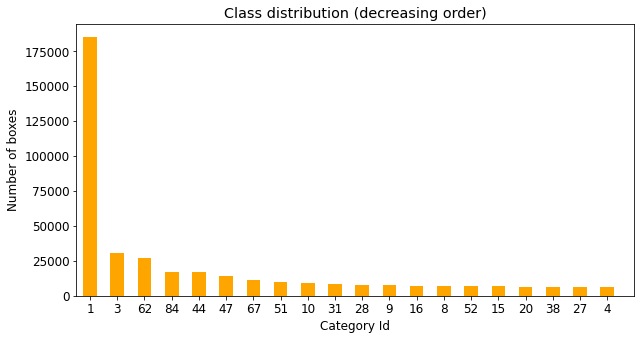

1 -> person
2 -> bicycle
3 -> car
4 -> motorcycle
5 -> airplane
6 -> bus
7 -> train
8 -> truck
9 -> boat
10 -> traffic light
11 -> fire hydrant
13 -> stop sign
14 -> parking meter
15 -> bench
16 -> bird
17 -> cat
18 -> dog
19 -> horse
20 -> sheep
21 -> cow
22 -> elephant
23 -> bear
24 -> zebra
25 -> giraffe
27 -> backpack
28 -> umbrella
31 -> handbag
32 -> tie
33 -> suitcase
34 -> frisbee
35 -> skis
36 -> snowboard
37 -> sports ball
38 -> kite
39 -> baseball bat
40 -> baseball glove
41 -> skateboard
42 -> surfboard
43 -> tennis racket
44 -> bottle
46 -> wine glass
47 -> cup
48 -> fork
49 -> knife
50 -> spoon
51 -> bowl
52 -> banana
53 -> apple
54 -> sandwich
55 -> orange
56 -> broccoli
57 -> carrot
58 -> hot dog
59 -> pizza
60 -> donut
61 -> cake
62 -> chair
63 -> couch
64 -> potted plant
65 -> bed
67 -> dining table
70 -> toilet
72 -> tv
73 -> laptop
74 -> mouse
75 -> remote
76 -> keyboard
77 -> cell phone
78 -> microwave
79 -> oven
80 -> toaster
81 -> sink
82 -> refrigerator
84 -> bo

In [134]:
# Class distribution
class2nboxes = {} 

for ann in root['annotations']:
    cat_id = ann['category_id']
    
    if cat_id in class2nboxes.keys():
        class2nboxes[cat_id] += 1
    else:
        class2nboxes[cat_id] = 1

sorted_c2nb = [(k,v)for k, v in sorted(class2nboxes.items(), reverse=True, key=lambda item: item[1])]

# top 20 classes
top = min(len(sorted_c2nb),20)

# to plot
y = [i[1] for i in sorted_c2nb[:top]]
x = [i[0] for i in sorted_c2nb[:top]]

plt.figure(figsize=(10,5))
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='orange')
plt.xlim(-0.5,len(y))
plt.xlabel('Category Id')
plt.ylabel('Number of boxes')
plt.title('Class distribution (decreasing order)')
plt.show()



categ_map = {x['id']: x['name'] for x in root['categories']}
for k in categ_map.keys():
    print(k,'->',categ_map[k])

## Class wise bounding box area distribution

In [135]:
# Class wise bounding box area distribution

bbox_areas = {} # key: class index, value -> a list of bounding box areas

for ann in root['annotations']:
    area = ann['area']
    cat_id = ann['category_id']
    
    if area <= 0.0:
        continue
    
    if cat_id in bbox_areas.keys():
        bbox_areas[cat_id].append(area)
    else:
        bbox_areas[cat_id] = [area]


bbox_avg_areas = []

for cat in bbox_areas.keys():
    areas = bbox_areas[cat]
    avg_area = int(sum(areas)/len(areas))
    
    bbox_avg_areas.append((cat,avg_area))

bbox_avg_areas = sorted(bbox_avg_areas, key = lambda x: x[1])

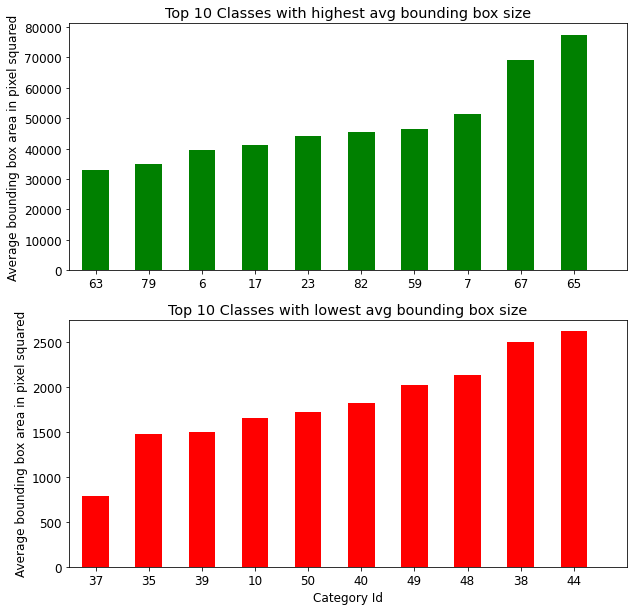

1 -> person
2 -> bicycle
3 -> car
4 -> motorcycle
5 -> airplane
6 -> bus
7 -> train
8 -> truck
9 -> boat
10 -> traffic light
11 -> fire hydrant
13 -> stop sign
14 -> parking meter
15 -> bench
16 -> bird
17 -> cat
18 -> dog
19 -> horse
20 -> sheep
21 -> cow
22 -> elephant
23 -> bear
24 -> zebra
25 -> giraffe
27 -> backpack
28 -> umbrella
31 -> handbag
32 -> tie
33 -> suitcase
34 -> frisbee
35 -> skis
36 -> snowboard
37 -> sports ball
38 -> kite
39 -> baseball bat
40 -> baseball glove
41 -> skateboard
42 -> surfboard
43 -> tennis racket
44 -> bottle
46 -> wine glass
47 -> cup
48 -> fork
49 -> knife
50 -> spoon
51 -> bowl
52 -> banana
53 -> apple
54 -> sandwich
55 -> orange
56 -> broccoli
57 -> carrot
58 -> hot dog
59 -> pizza
60 -> donut
61 -> cake
62 -> chair
63 -> couch
64 -> potted plant
65 -> bed
67 -> dining table
70 -> toilet
72 -> tv
73 -> laptop
74 -> mouse
75 -> remote
76 -> keyboard
77 -> cell phone
78 -> microwave
79 -> oven
80 -> toaster
81 -> sink
82 -> refrigerator
84 -> bo

In [136]:
top = min(10, len(bbox_avg_areas))

plt.figure(figsize=(10,10))

y = [item[1] for item in bbox_avg_areas[-top:]]
x = [item[0] for item in bbox_avg_areas[-top:]]

y2 = [item[1] for item in bbox_avg_areas[:top]]
x2 = [item[0] for item in bbox_avg_areas[:top]]

plt.subplot(211)
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='green')
plt.xlim(-0.5,len(y))
plt.xlabel('Category Id')
plt.ylabel('Average bounding box area in pixel squared')
plt.title('Top '+str(top)+' Classes with highest avg bounding box size')


plt.subplot(212)
plt.bar(np.arange(len(y2)),y2, width=0.5,tick_label=x2,color='red')
plt.xlim(-0.5,len(y2))
plt.xlabel('Category Id')
plt.ylabel('Average bounding box area in pixel squared')
plt.title('Top '+str(top)+' Classes with lowest avg bounding box size')
plt.show()




categ_map = {x['id']: x['name'] for x in root['categories']}
for k in categ_map.keys():
    print(k,'->',categ_map[k])

In [137]:
# root['annotations']

## Class wise 'occurance' in Captions


In [174]:
# caption['annotations']

In [140]:
caption_list=[]
for x in caption['annotations']:
  caption_list.append(x['caption'])

In [177]:
caption_list[1:8]

['A panoramic view of a kitchen and all of its appliances.',
 'A blue and white bathroom with butterfly themed wall tiles.',
 'A panoramic photo of a kitchen and dining room',
 'A graffiti-ed stop sign across the street from a red car ',
 'A vandalized stop sign and a red beetle on the road',
 'A bathroom with a border of butterflies and blue paint on the walls above it.',
 'An angled view of a beautifully decorated bathroom.']

In [142]:
len(caption_list)

414113

In [143]:
caption_list[9]

'A sink and a toilet inside a small bathroom.'

In [144]:
if 'toilet' in caption_list[9]:
  print("bro")

bro


In [145]:
class_list=[]
for x in root['categories']:
  class_list.append(x['name'])

In [178]:
# class_list

In [147]:
cnt_frequency=[]
for class_name in class_list:
  cnt=0;
  for caption in caption_list:
    if class_name in caption:
      cnt +=1
  cnt_frequency.append(cnt);
  print(class_name + ' : ' + str(cnt))

person : 17269
bicycle : 2086
car : 14819
motorcycle : 6428
airplane : 4261
bus : 12347
train : 11163
truck : 5935
boat : 5925
traffic light : 1666
fire hydrant : 3439
stop sign : 2866
parking meter : 1096
bench : 6682
bird : 5269
cat : 16140
dog : 14582
horse : 8828
sheep : 3606
cow : 4583
elephant : 7059
bear : 7909
zebra : 5890
giraffe : 8205
backpack : 587
umbrella : 6949
handbag : 64
tie : 4108
suitcase : 1923
frisbee : 3842
skis : 3986
snowboard : 3314
sports ball : 2
kite : 6329
baseball bat : 1332
baseball glove : 146
skateboard : 9781
surfboard : 4904
tennis racket : 2134
bottle : 2012
wine glass : 794
cup : 2770
fork : 1169
knife : 1308
spoon : 629
bowl : 4575
banana : 4565
apple : 1891
sandwich : 4011
orange : 4316
broccoli : 2321
carrot : 1545
hot dog : 1863
pizza : 8913
donut : 1983
cake : 6693
chair : 5922
couch : 4268
potted plant : 183
bed : 9649
dining table : 451
toilet : 7268
tv : 875
laptop : 6623
mouse : 1137
remote : 1856
keyboard : 2152
cell phone : 3578
microwav

In [148]:
cat_list=[]
for k in categ_map.keys():
    cat_list.append(k)

In [150]:
word_cnt_list=[]
for k in cnt_frequency:
  word_cnt_list.append(k)

In [170]:
word_cnt_tuple_list=[]
for i in range(len(cat_list)):
  a = cat_list[i]
  b = word_cnt_list[i]
  word_cnt_tuple_list.append((a,b))

word_cnt_tuple_list = sorted(word_cnt_tuple_list, key = lambda x: x[1])

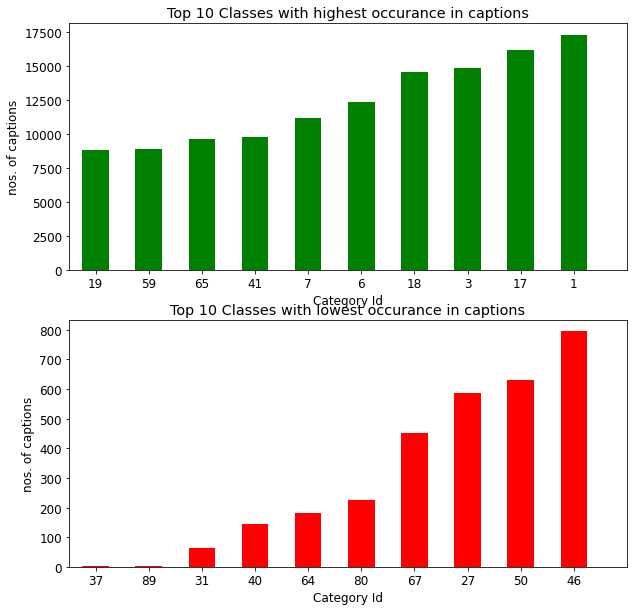

1 -> person
2 -> bicycle
3 -> car
4 -> motorcycle
5 -> airplane
6 -> bus
7 -> train
8 -> truck
9 -> boat
10 -> traffic light
11 -> fire hydrant
13 -> stop sign
14 -> parking meter
15 -> bench
16 -> bird
17 -> cat
18 -> dog
19 -> horse
20 -> sheep
21 -> cow
22 -> elephant
23 -> bear
24 -> zebra
25 -> giraffe
27 -> backpack
28 -> umbrella
31 -> handbag
32 -> tie
33 -> suitcase
34 -> frisbee
35 -> skis
36 -> snowboard
37 -> sports ball
38 -> kite
39 -> baseball bat
40 -> baseball glove
41 -> skateboard
42 -> surfboard
43 -> tennis racket
44 -> bottle
46 -> wine glass
47 -> cup
48 -> fork
49 -> knife
50 -> spoon
51 -> bowl
52 -> banana
53 -> apple
54 -> sandwich
55 -> orange
56 -> broccoli
57 -> carrot
58 -> hot dog
59 -> pizza
60 -> donut
61 -> cake
62 -> chair
63 -> couch
64 -> potted plant
65 -> bed
67 -> dining table
70 -> toilet
72 -> tv
73 -> laptop
74 -> mouse
75 -> remote
76 -> keyboard
77 -> cell phone
78 -> microwave
79 -> oven
80 -> toaster
81 -> sink
82 -> refrigerator
84 -> bo

In [172]:
top = min(10, len(word_cnt_tuple_list))

plt.figure(figsize=(10,10))

y = [item[1] for item in word_cnt_tuple_list[-top:]]
x = [item[0] for item in word_cnt_tuple_list[-top:]]

y2 = [item[1] for item in word_cnt_tuple_list[:top]]
x2 = [item[0] for item in word_cnt_tuple_list[:top]]

plt.subplot(211)
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='green')
plt.xlim(-0.5,len(y))
plt.xlabel('Category Id')
plt.ylabel('nos. of captions')
plt.title('Top '+str(top)+' Classes with highest occurance in captions')


plt.subplot(212)
plt.bar(np.arange(len(y2)),y2, width=0.5,tick_label=x2,color='red')
plt.xlim(-0.5,len(y2))
plt.xlabel('Category Id')
plt.ylabel('nos. of captions')
plt.title('Top '+str(top)+' Classes with lowest occurance in captions')
plt.show()


categ_map = {x['id']: x['name'] for x in root['categories']}
for k in categ_map.keys():
    print(k,'->',categ_map[k])